In [1]:
import os
import time
from tempfile import TemporaryDirectory

import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.optim as optim
import torchvision
from ai import get_default_device
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms

cudnn.benchmark = True

In [2]:
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["TORCH_USE_CUDA_DSA"] = "1"

In [3]:
plt.rcParams["axes.unicode_minus"] = False
fontprop = fm.FontProperties(fname="/usr/share/fonts/truetype/malgun.ttf")

## 데이터 로딩


In [4]:
mean = (0.5, 0.5, 0.5)
std = (0.5, 0.5, 0.5)

In [5]:
data_transforms = {
    "train": transforms.Compose(
        [
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean, std),
        ]
    ),
    "val": transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean, std)]),
}

In [6]:
data_dir = "./data/ResNet18"
os.listdir(data_dir)

['train', 'val']

In [7]:
image_datasets = {
    x: datasets.ImageFolder(os.path.join(data_dir, x), transform=data_transforms[x])
    for x in ["train", "val"]
}

image_datasets

{'train': Dataset ImageFolder
     Number of datapoints: 1054
     Root location: ./data/ResNet18/train
     StandardTransform
 Transform: Compose(
                RandomHorizontalFlip(p=0.5)
                ToTensor()
                Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
            ),
 'val': Dataset ImageFolder
     Number of datapoints: 180
     Root location: ./data/ResNet18/val
     StandardTransform
 Transform: Compose(
                ToTensor()
                Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
            )}

In [8]:
dataloaders = {
    x: torch.utils.data.DataLoader(
        image_datasets[x], batch_size=64, shuffle=True, num_workers=8
    )
    for x in ["train", "val"]
}

dataloaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x7cf08e7651d0>,
 'val': <torch.utils.data.dataloader.DataLoader at 0x7cf0943e3410>}

In [9]:
dataset_sizes = {x: len(image_datasets[x]) for x in ["train", "val"]}
dataset_sizes

{'train': 1054, 'val': 180}

In [10]:
class_names = image_datasets["train"].classes
class_names

['Negative', 'Neutral', 'Positive']

In [11]:
device = get_default_device()
device

device(type='cuda')

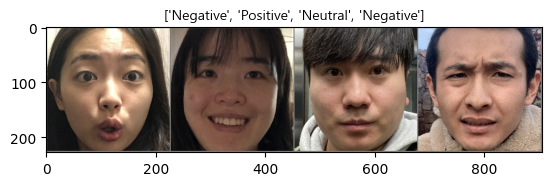

In [12]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title, fontproperties=fontprop)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders["train"]))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs[:4])

imshow(out, title=[class_names[x] for x in classes[:4]])

## Training


In [13]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, "resnet18_best_model_params.pt")

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f"Epoch {epoch + 1}/{num_epochs}")
            print("-" * 10)

            # Each epoch has a training and validation phase
            for phase in ["train", "val"]:
                if phase == "train":
                    model.train()  # Set model to training mode
                else:
                    model.eval()  # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == "train"):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == "train":
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == "train":
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

                # deep copy the model
                if phase == "val" and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(
            f"Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s"
        )
        print(f"Best val Acc: {best_acc:4f}")

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model

## Visualizing the model predictions


In [14]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders["val"]):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis("off")
                ax.set_title(
                    f"label: {class_names[labels.data[j]]} predicted: {class_names[preds[j]]}",
                    fontproperties=fontprop,
                )
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

## Finetuning the ConvNet


In [15]:
model_ft = models.resnet18(weights="IMAGENET1K_V1")
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
# optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001, weight_decay=0.0001)
# optimizer_ft = optim.RMSProp(model_ft.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

## Train and evaluate


In [16]:
model_ft = train_model(
    model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=20
)

Epoch 1/20
----------
train Loss: 0.5448 Acc: 0.8036
val Loss: 1.4092 Acc: 0.7500

Epoch 2/20
----------
train Loss: 0.2672 Acc: 0.8947
val Loss: 0.7800 Acc: 0.8556

Epoch 3/20
----------
train Loss: 0.1774 Acc: 0.9241
val Loss: 0.3782 Acc: 0.8667

Epoch 4/20
----------
train Loss: 0.1203 Acc: 0.9488
val Loss: 0.3883 Acc: 0.8778

Epoch 5/20
----------
train Loss: 0.1183 Acc: 0.9535
val Loss: 0.4581 Acc: 0.8500

Epoch 6/20
----------
train Loss: 0.0726 Acc: 0.9744
val Loss: 1.1255 Acc: 0.7389

Epoch 7/20
----------
train Loss: 0.0562 Acc: 0.9801
val Loss: 0.6511 Acc: 0.8611

Epoch 8/20
----------
train Loss: 0.0221 Acc: 0.9943
val Loss: 0.5643 Acc: 0.8667

Epoch 9/20
----------
train Loss: 0.0174 Acc: 0.9962
val Loss: 0.5348 Acc: 0.8722

Epoch 10/20
----------
train Loss: 0.0109 Acc: 0.9972
val Loss: 0.5124 Acc: 0.8722

Epoch 11/20
----------
train Loss: 0.0073 Acc: 0.9991
val Loss: 0.5121 Acc: 0.8778

Epoch 12/20
----------
train Loss: 0.0073 Acc: 0.9991
val Loss: 0.5174 Acc: 0.8722

E

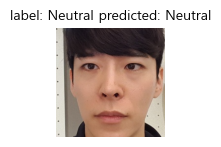

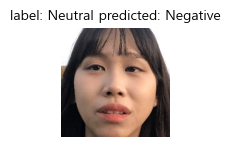

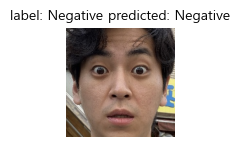

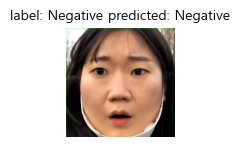

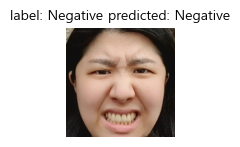

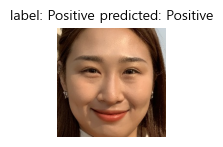

In [17]:
visualize_model(model_ft)